In [1]:
import pymesh
import numpy as np
import matplotlib.pyplot as plt
import meshio

In [2]:
# load a simplicial mesh
mesh = meshio.read("/home/aspadotto/meshes/square.msh")

In [3]:
# parse the raw data structures
Nnode = mesh.points.shape[0]
Nelements = mesh.cells[1].__dict__['data'].shape[0]
elements = mesh.cells[1].__dict__['data']
barycenters = np.zeros((Nelements,2))
edge_barycenters = np.zeros((Nelements,3,2))
nodes   = mesh.points
boundary_edges = mesh.cells[0].__dict__['data']

for i in range (Nelements):
    x = 0.
    y = 0.
    triangle = elements[i,:]
    for j in range (3):
        #calculate element barycenter
        x = x + 1/3*nodes[elements[i,j],0]
        y = y + 1/3*nodes[elements[i,j],1]
        #calculate edge barycenter
        start = j
        if j==2:
            end = 0
        else:
            end = j+1
        xx  = 0.5*(nodes[triangle[start], 0]+nodes[triangle[end],0])
        yy  = 0.5*(nodes[triangle[start], 1]+nodes[triangle[end],1])
        edge_barycenters [i,j,:] = [xx,yy]
    barycenters[i,:] = [x,y]

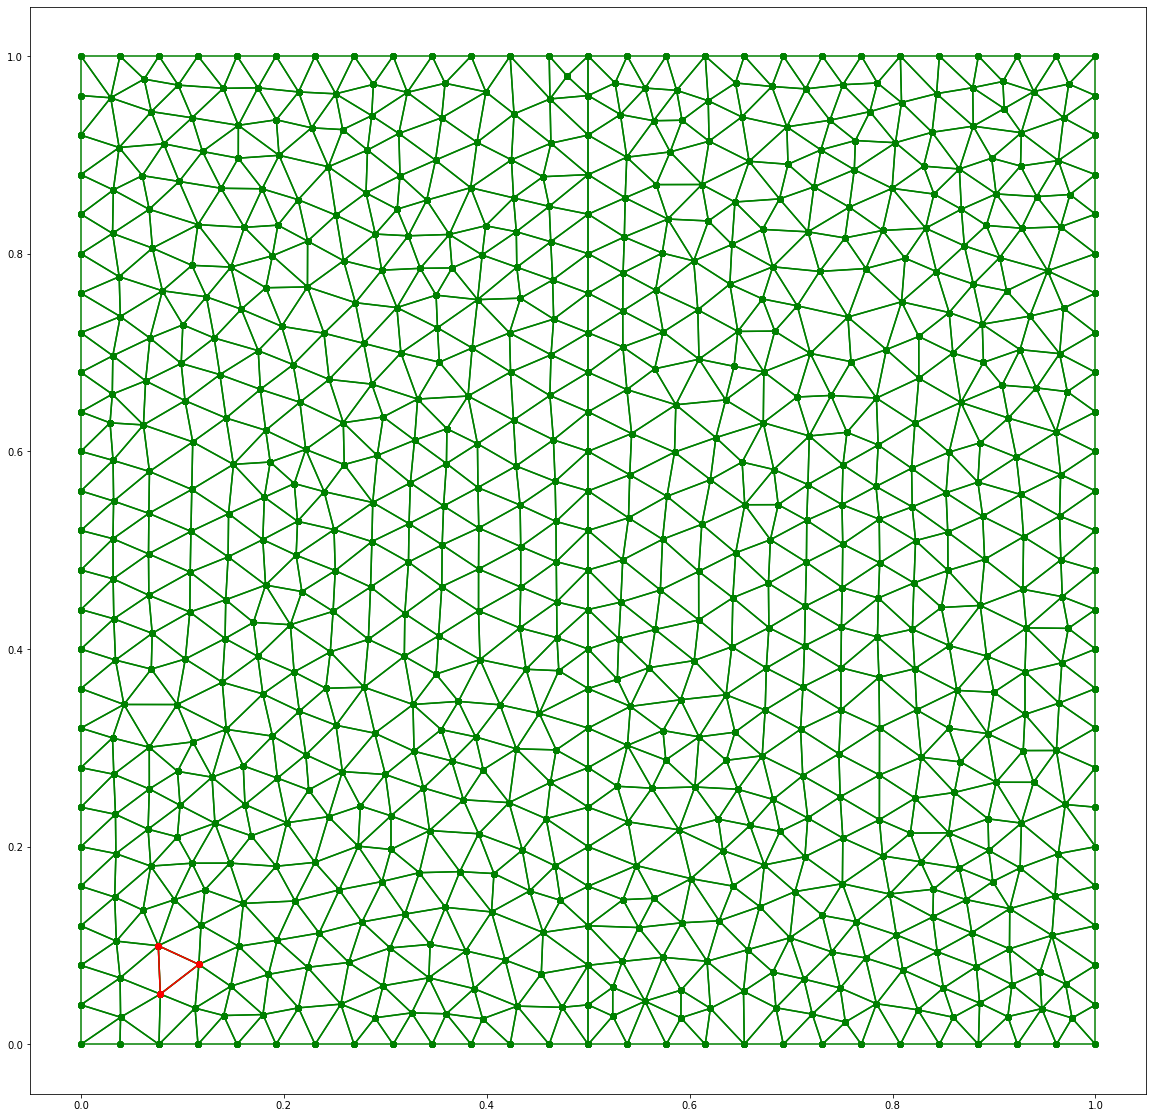

In [14]:
#a look at the primal mesh with barycenters
fig, ax  = plt.subplots(figsize = (20,20))
for i in range (Nelements):
    triangle = elements[i,:]
    for j in range(3): 
        start = j
        if j==2:
            end = 0
        else:
            end = j+1
        xx  = (nodes[triangle[start], 0], nodes[triangle[end],0])
        yy  = (nodes[triangle[start], 1], nodes[triangle[end],1])
        edge= ax.plot(xx,yy, 'go-')

i = 230
triangle = elements[i,:]
for j in range(3): 
        start = j
        if j==2:
            end = 0
        else:
            end = j+1
        xx  = (nodes[triangle[start], 0], nodes[triangle[end],0])
        yy  = (nodes[triangle[start], 1], nodes[triangle[end],1])
        edge= ax.plot(xx,yy, 'ro-')


# check that neighbours are well set
#l = 450
#ax.plot(nodes[l][0], nodes[l][1], 'bo', markersize = 10)
#for neigh in neighbours[l]:
#    ax.plot(nodes[neigh][0], nodes[neigh][1], 'ro', markersize = 10)

In [104]:
#DEFORMATION (TO INDUCE INSTABILITY)
def deform (x,y):
    return [x,0.5 +(2-x)*(y-0.5)]
def reform (x,y): #inverse deformation
    return [x, (y-0.5)/(2-x) + 0.5]
nodes[:,0], nodes[:,1] = deform(nodes[:,0],nodes[:,1])
barycenters[:,0], barycenters[:,1] = deform(barycenters[:,0],barycenters[:,1])

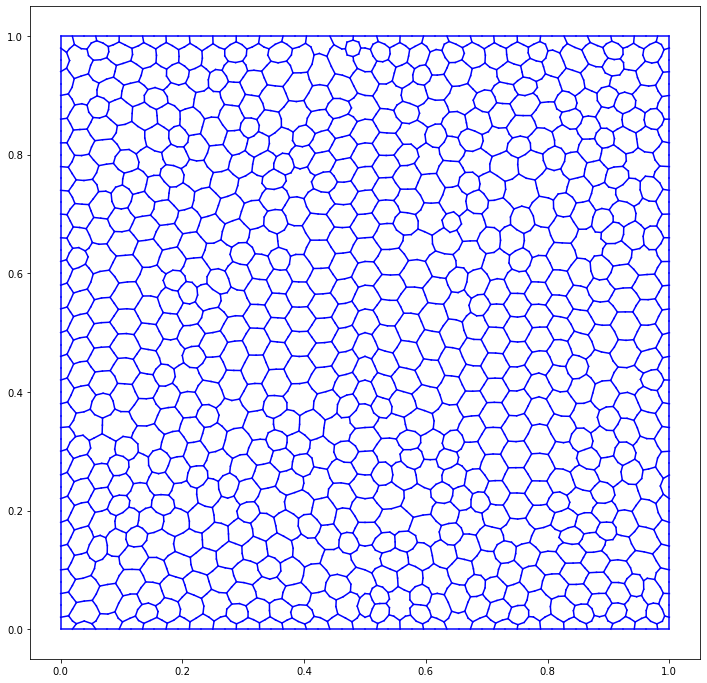

In [64]:
# a look at the dual mesh
fig, ax = plt.subplots(figsize = (12,12))
for i in range (Nelements):
    [x0,y0] = barycenters[i,:]
    for j in range (3):
         [x1,y1] = edge_barycenters[i,j,:]
         facet= ax.plot([x0,x1],[y0,y1],'b-') 
for i in range(boundary_edges.shape[0]):
    xx = (nodes[boundary_edges[i,0],0],nodes[boundary_edges[i,1],0])
    yy = (nodes[boundary_edges[i,0],1],nodes[boundary_edges[i,1],1])
    bface = ax.plot(xx,yy,'b-')

In [16]:
#need to mark nodes on the boundary and the interface
bnd_marker = np.zeros(Nnode)
for i in range (Nnode):
    if nodes[i,1]==0.:
        bnd_marker[i] = 1
    elif nodes[i,1]==1.:
        bnd_marker[i] = 3
    elif nodes [i,0]==0.:
        bnd_marker[i] = 4
    elif nodes [i,0]==1.:
        bnd_marker[i] = 2
    else:
        bnd_marker[i] = 0
    if nodes[i,0]==0.5:
        bnd_marker[i] = -1 #interface

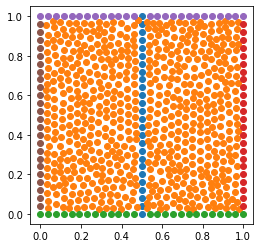

In [17]:
fig, ax = plt.subplots(figsize = (4,4))
for i in range(6):
   mask = (bnd_marker == i-1)
   bnd = nodes[mask,:]
   bndline = ax.scatter(bnd[:,0], bnd[:,1])

In [18]:
#need to build node2node connectivity (neighbours)
#need to build node2element connectivity (near_cells)

neighbours = [[]]*Nnode
near_cells = [[]]*Nnode
for i in range (Nelements):
    elem = elements[i,:]
    for j in range(3):
        # fill near_cells
        if (near_cells[elem[j]]==[]):
            near_cells[elem[j]] = [i]
        else:
            near_cells[elem[j]].append(i)
        # fill neighbours 
        for k in (1,2):
            ind = (j+k)%3 #cyclic index
            if (neighbours[elem[j]]==[]):
                neighbours[elem[j]] =[elem[ind]]
            elif not(elem[ind] in neighbours[elem[j]]):
                neighbours[elem[j]].append(elem[ind])

(-0.1, 1.1)

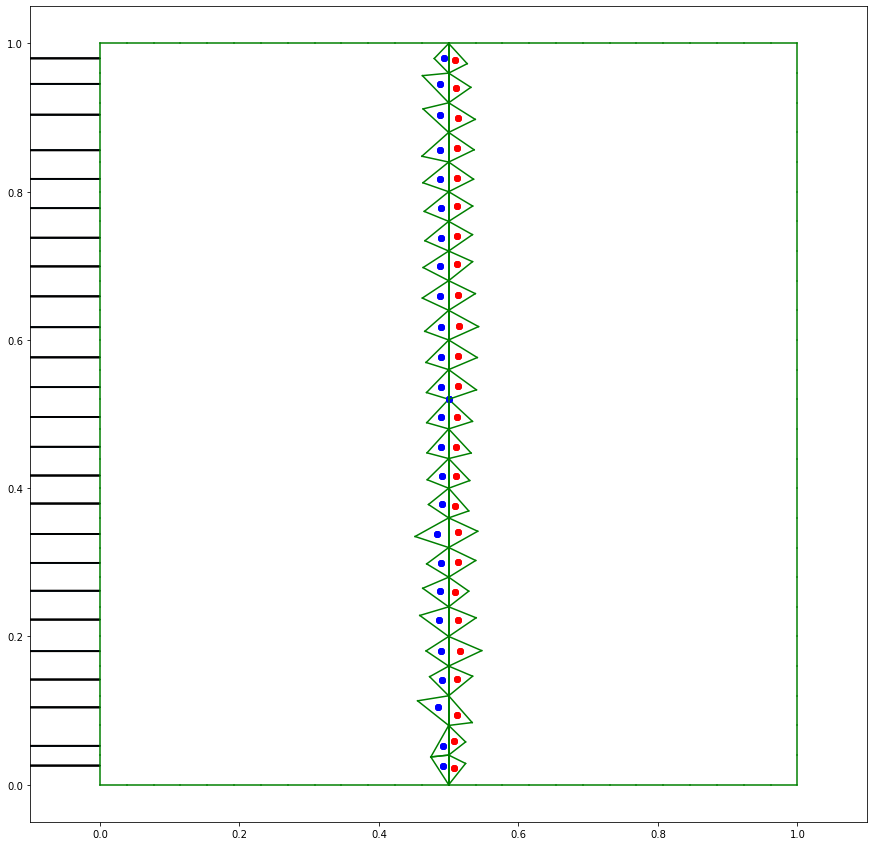

In [16]:
#need to collect information at the interface:
  #collect edges on interface
  #each edge has 2 facing elements
  # each edge has the structure [[node_top,node_bott],[elem-,elem+], |E|]
gamma_nodes = [ i for i,n in enumerate(bnd_marker) if n==-1]
interface   = []

for i in gamma_nodes:
    for j in neighbours[i]:
        if (bnd_marker[j]==-1 and nodes[j][1] < nodes[i][1] ):
                    pair_nodes = [i, j]
                    pair_elems= [None]*2
                    for k in near_cells[i]:
                        elem = elements[k]
                        if (j in elem):
                            if (sigma[k]==sigma1):
                                pair_elems[0] = k
                            elif (sigma[k]==sigma2):
                                pair_elems[1] = k
                    m_E = np.sqrt(np.square(
                                  nodes[pair_nodes[0]][0]-nodes[pair_nodes[1]][0])+ 
                                  np.square(
                                  nodes[pair_nodes[0]][1]-nodes[pair_nodes[1]][1])) 
                    interface.append([pair_nodes, pair_elems, m_E])

fig, ax = plt.subplots(figsize=(15,15))
for [node_pair,elems, m_E] in interface:
    normal_gamma = normal[elems[1],
                          [m for m,x in enumerate(elements[elems[1]]) if x==node_pair[0]][0],
                           :]
    normal_gamma = normal_gamma/np.linalg.norm(normal_gamma)
    for elem in elems:
        for i in range(3):
            
            j =(i+1)%3
            node1 = elements[elem][i]
            if node1==30:
                ax.plot(nodes[node1][0], nodes[node1][1], 'bo')
            node2 = elements[elem][j]
            xx = [nodes[node1][0],nodes[node2][0]]
            yy = [nodes[node1][1],nodes[node2][1]]
            ax.plot(xx,yy,'g-')
            if (sigma[elem]==sigma1):
                ax.plot(barycenters[elem,0], barycenters[elem,1], 'bo')
                ax.arrow(0., barycenters[elem,1], normal_gamma[0], normal_gamma[1])
            else:
                ax.plot(barycenters[elem,0], barycenters[elem,1], 'ro')
for i in range(boundary_edges.shape[0]):
    xx = (nodes[boundary_edges[i,0],0],nodes[boundary_edges[i,1],0])
    yy = (nodes[boundary_edges[i,0],1],nodes[boundary_edges[i,1],1])
    bface = ax.plot(xx,yy,'g-')

plt.xlim([-0.1,1.1])

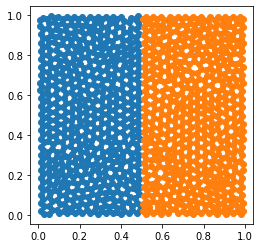

In [19]:
#interface along diagonal, sigma selected according to where barycenter falls
#sigma1 = 0.1
#sigma2 = 1
sigma1 = 0.1
sigma2 = 1
mask = (barycenters[:,0]<0.5)
sigma = np.zeros((Nelements))
sigma[mask] = sigma1
sigma[mask[:]==False] = sigma2

fig, ax = plt.subplots(figsize = (4,4))
pt1 = ax.scatter(barycenters[mask,0], barycenters[mask,1])
pt2= ax.scatter(barycenters[mask[:] == False,0], barycenters[mask[:]==False,1])

NameError: name 'normal' is not defined

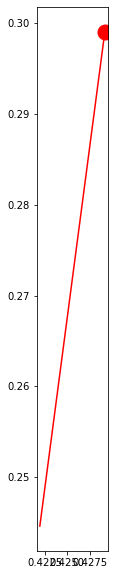

In [20]:
#check ordering
fig,ax = plt.subplots(figsize = (10,10))
plt.gca().set_aspect('equal', adjustable='box')
for i in range(1):
    colors = ['r', 'b', 'g']
    elem = elements[i]
    for n in range(3):
        dot = ax.plot(nodes[elem[n]][0], nodes[elem[n]][1], colors[n], markersize=15, marker ='o')
        tri = ax.plot([nodes[elem[n],0],nodes[elem[(n+1)%3],0]], [nodes[elem[(n)%3],1],nodes[elem[(n+1)%3],1]],colors[n])
        edge_bary = 0.5*(nodes[elem[n]]+nodes[elem[(n+1)%3]])
        norm = ax.plot([edge_bary[0],edge_bary[0]+ normal[i,n,0]], 
                 [edge_bary[1],edge_bary[1] + normal[i,n,1]], colors[n])


need to build $\omega_{ij}$ (for the moment without stabilization):

- loop over the elements
- calculate the normals and the averages
- from each element 6 contributions to the omega_ij


In [21]:
normal = np.zeros((Nelements, 3,2))
rot = np.array([[0,1],[-1,0]])

#fig, ax = plt.subplots(figsize = (20,20))

#calculate normals
for k in range(Nelements):
    elem = elements[k]
    #loop over the edges
    for i in range(3):
        j = (i+1)%3
        edge = nodes[elem[j]]-nodes[elem[i]]
        edge_bary = 0.5*(nodes[elem[j]]+nodes[elem[i]])
        #ax.plot([nodes[elem[j]][0],nodes[elem[i]][0]], [nodes[elem[j]][1],nodes[elem[i]][1]],'r-')
        edge = edge[0:2] #only components in xy plane
        normal[k,i,:]= np.dot(rot,edge)
        #ax.arrow(edge_bary[0], edge_bary[1], normal[k,i,0], normal[k,i,1])

omega = [[]]*Nnode
m_T = np.zeros((Nelements))

#calculate omega_ij
#loop over elements
for k in range(Nelements):
    elem = elements[k]
    #loop over nodes
    for i in range(3):
       #loop over neighbours 
       for jj in (1,2):
            j = (i+jj)%3
            e_avg_i = 0.5*(normal[k,i,:] + normal[k,(i+2)%3,:])
            e_avg_j = 0.5*(normal[k,j,:] + normal[k,(j+2)%3,:])
            #area calculation (Erone)
            a = np.linalg.norm(normal[k,0,:])
            b = np.linalg.norm(normal[k,1,:])
            c = np.linalg.norm(normal[k,2,:])
            p = 0.5*(a+b+c)
            m_T [k]= np.sqrt(p*(p-a)*(p-b)*(p-c))
            index_j = [n for n,x in enumerate(neighbours[elem[i]]) if x == elem[j]][0]
            if (omega[elem[i]]==[]):
                omega[elem[i]]=[0.]
            while (len(omega[elem[i]])<(index_j+1)):
                omega[elem[i]].append(0.)
            omega[elem[i]][index_j] = omega[elem[i]][index_j] - sigma[k]/m_T[k]*np.dot(e_avg_i,e_avg_j)
            
#structure omega as en element-wise tensor
omega_bis = np.zeros([3,3,Nelements])
for k in range(Nelements):
    for i in range(3):
        for j in range(3):
            e_avg_i = 0.5*(normal[k,i,:] + normal[k,(i+2)%3,:])
            e_avg_j = 0.5*(normal[k,j,:] + normal[k,(j+2)%3,:])
            #area calculation (Erone)
            a = np.linalg.norm(normal[k,0,:])
            b = np.linalg.norm(normal[k,1,:])
            c = np.linalg.norm(normal[k,2,:])
            p = 0.5*(a+b+c)
            m_T [k]= np.sqrt(p*(p-a)*(p-b)*(p-c))
            omega_bis[i,j,k] = sigma[k]/m_T[k]*np.dot(e_avg_i,e_avg_j)

In [45]:
omega_bis[:,:,0]

array([[ 0.05017807, -0.01634971, -0.03382836],
       [-0.01634971,  0.05514985, -0.03880014],
       [-0.03382836, -0.03880014,  0.0726285 ]])

We need to add to the $\omega_{ij}$ the stabilization contribution:
- loop over the interface edges
- loop over the 2 interface nodes ($i$)
- loop over the other 2 nodes of the cell ($j$)
- update $\omega_{ij}$
I have already stored the normals. Each element has its nodes stored counter-clock-wise. If you want to refer to the normal on the opposite side w.r.t. to node $i$ take the $i+1$ normal 

In [25]:
#stabilization
delta = 1
for [pair, elems, m_E] in interface:
    normal_gamma = normal[elems[1],
                          [m for m,x in enumerate(elements[elems[1]]) if x==pair[0]][0],
                           :]
    normal_gamma = -normal_gamma/np.linalg.norm(normal_gamma)
    for elem in elems:
        signed_sigma = sigma[elem]*(int(sigma[elem]==sigma1)-int(sigma[elem]==sigma2))
        for i in pair: #calculate the second factor (depending on i only)
            local_i   = [m for m,x in enumerate(elements[elem]) if x==i][0] #local index of i
            vector2 = np.zeros(2)
            factor2 = 0.
            for elem_bis in elems:
                signed_sigma_bis = sigma[elem_bis]*(-int(sigma[elem_bis]==sigma1)+int(sigma[elem_bis]==sigma2))
                local_i_bis   = [m for m,x in enumerate(elements[elem_bis]) if x==i][0] #local index of i
                vector2 = vector2 + (-0.5)*signed_sigma_bis/m_T[elem_bis]* \
                                           normal[elem_bis,
                                          (local_i_bis+1)%3,
                                           :]
            factor2 = np.dot(vector2,normal_gamma)*m_E*m_E
            #calculate the first factor (depending on j also)
            other_two = [n for n in elements[elem] if n!=i] #the other two nodes
            for j in other_two:
                    local_j   = [m for m,x in enumerate(elements[elem]) if x==j][0]
                    vector1 = (-0.5)*signed_sigma/m_T[elem]*normal[elem,(local_j+1)%3,:]
                    factor1 = np.dot(vector1,normal_gamma)
                    idx_as_neigh_j = [m for m,x in enumerate(neighbours[i]) if x==j][0]#index of j as a neighbour of i 
                    #print(omega[i][idx_as_neigh_j], delta*factor1*factor2)
                    omega[i][idx_as_neigh_j] = omega[i][idx_as_neigh_j] - delta*factor1*factor2
                                               
                    


NameError: name 'interface' is not defined

In [ ]:
#once the matrix coefficients built we want to configure a CG scheme
#we need to define a function for product matrix-vector
#we need to define a function to assign strongly boundary conditions
#we need to assign the rhs (null, if no sources)

In [9]:
def make_product(u):
    b = np.zeros((Nnode))
    for i in range (Nnode):
        if (bnd_marker[i]!=2 and bnd_marker[i]!=4):
            for j in range(len(neighbours[i])):
                b[i] = b[i] +omega[i][j]*(u[i]-u[neighbours[i][j]])
        else:
            b[i] = u[i]
    return b

#version for omega given as element-wise tensor
def make_product_bis(u):
    b = np.zeros((Nnode))
    for k in range(Nelements):
        for i in range(3):
            ino_i = elements[k,i] 
            if (bnd_marker[ino_i]!=2 and bnd_marker[ino_i]!=4):
                for j in range(3):
                    ino_j= elements[k,j]
                    b[ino_i] = b[ino_i] + omega_bis[i,j,k]*u[ino_j]
            else:
                b[ino_i] = u[ino_i]        
    return b


for i in range (Nnode):
    x,y = nodes[i][0], nodes[i][1]
    if abs(x)<1e-6:
        bnd_marker[i] = 2
    elif (1-x)<1e-6:
        bnd_marker[i] = 4 #need the point (0.,0.5) and (1.,1.5) to be recognized on the boundary
            
#impose BCs on 
def impose_bc(u):
    eps = 1e-6
    mask = (bnd_marker>0)
    for i in range(Nnode):
        if (mask[i]):
            x = nodes[i,0]
            y = nodes[i,1]
   #         x,y = reform(x,y)
            if (abs(x)<eps):
                u[i] = 0.
            elif (abs(x-1)<eps):
                u[i] = 1.
           # elif (abs(y)<eps or abs(y-1.)<eps):
           #     if (x<0.5):
           #        u[i] = (2*sigma2)/(sigma1+sigma2)*x
           #    else:
           #         u[i] = 1-(2*sigma1)/(sigma1+sigma2)*(1-x)
    return u
#------>you can change the datum ()

In [10]:
#CG loop (currently running version with element-wise omega)
    b = np.zeros((Nnode))
    u = np.zeros((Nnode)) 
    impose_bc(u)
    impose_bc(b)
    r = b - make_product(u)
    r[bnd_marker==2]  = 0.
    r[bnd_marker==4]  = 0.
    p =r
    rho_0 = np.dot(r,r)
    theta = np.dot(p, make_product(p))


it = 0
maxiter = 2000
while (rho_0 > 1e-12 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    impose_bc(u) #correction
    r = r - alpha*make_product(p)
    r[bnd_marker==2] =0. #correction
    r[bnd_marker==4] =0. #correction
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
    p[bnd_marker==2] =0. #correction
    p[bnd_marker==4] =0. #correction
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

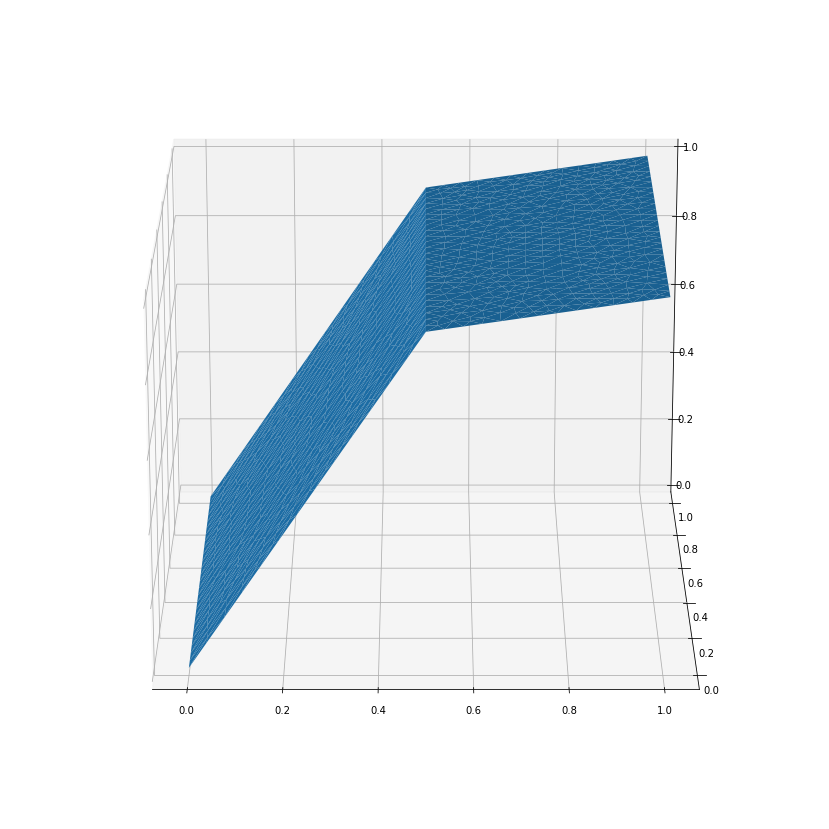

In [11]:
#visualization
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize = (15,15))
ax  = fig.add_subplot(111,projection='3d')
ax.azim = -90
ax.elev = 20.
surf = ax.plot_trisurf(nodes[:,0],nodes[:,1], u)
plt.show()

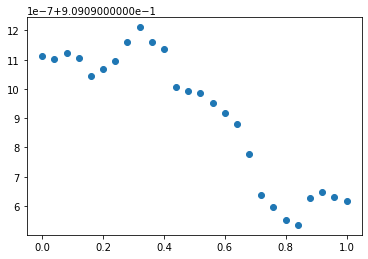

In [74]:
fig,ax = plt.subplots()
ax.plot(nodes[bnd_marker==-1,1], u[bnd_marker==-1],'o')
#ax.plot(nodes[bnd_marker==1,0], u[bnd_marker==1],'o')

In [22]:
#quadrature over a segment: Simpson 3/8 formula, doe = 3
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/3
    mid2 = a + (b-a)*2/3
    if   (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/8*(fun(mid1[0],mid1[1]) + 
                                       fun(mid2[0],mid2[1])*2  +
                                       fun(b[0], b[1]))
    elif (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 
                                       2*fun(mid1[0],mid1[1])+
                                       fun(mid2[0],mid2[1]))
    else: 
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 3*fun(mid1[0],mid1[1]) +
                                       3*fun(mid2[0],mid2[1]) + fun(b[0], b[1]))

In [23]:
#quadrature over a segment: Boole formula
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/4
    mid2 = a + (b-a)*2/4
    mid3 = a + (b-a)*3/4
    if   (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        24*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                        8*fun(mid3[0],mid3[1]))
    elif (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/90*(8*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                       24*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))
    else: 
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        32*fun(mid1[0],mid1[1]) +
                                        12*fun(mid2[0],mid2[1]) + 
                                        32*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))

In [24]:
my_fun = lambda x,y: x*y
a = np.array([0.,0.,0.])
b = np.array([1.,1.,0.])/np.sqrt(2)

print (simpson(a,b,lambda x,y: my_fun(x,y)))

0.1666666666666666


[[ 2.         -0.03595629 -0.07893381]
 [ 2.          0.07800566  0.01110141]
 [ 2.         -0.04204937  0.0678324 ]]
[[ 3.83874582e-03 -2.60197933e-20  5.08219768e-20]
 [-2.60197933e-20  7.31432050e-07  6.81241197e-08]
 [ 5.08219768e-20  6.81241197e-08  8.76115574e-07]]
[[ 1.55854062e-19  1.02702745e-19 -2.37169225e-19]
 [ 9.58521176e-07 -2.07947159e-06  1.12095041e-06]
 [ 2.10421417e-06 -2.95940925e-07 -1.80827325e-06]]
[[ 6.39790970e-04  6.39790970e-04  6.39790970e-04]
 [-3.83408471e-06  8.31788634e-06 -4.48380164e-06]
 [-8.41685669e-06  1.18376370e-06  7.23309299e-06]]


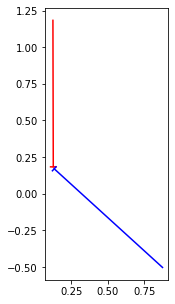

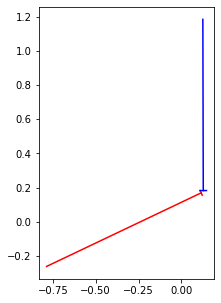

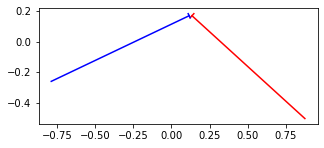

In [31]:
#RECONSTRUCTION
REC = []
S = [] 
#loop over elements
for t in range(Nelements):
    node_per_elem = 3
    dim_basis     = 3 #dimension of basis of R,c2(T) 
    V = np.zeros ((node_per_elem, dim_basis)) #evaluation matrix
    M = np.zeros ((dim_basis, dim_basis))     #the mass matrix to invert
    B1 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 1)
    B2 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 2)
    x_T = np.array(barycenters[t,:])
    #define the psi_i (for edge contribution of B)
    psi = [None for _ in range(dim_basis)]
    psi [0] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])
    psi [1] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(x-x_T[0])
    psi [2] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(y-x_T[1])
    #define the phi_i (for V)
    phi = [None for _ in range(dim_basis)]
    phi [0] = lambda x,y: 2.
    phi [1] = lambda x,y: 3*(x - x_T[0])
    phi [2] = lambda x,y: 3*(y - x_T[1])
    #define the csi_ij (integrated phi_i*phi_j, for M)
    csi = [[None for _ in range(dim_basis)] for _ in range (dim_basis)]
    csi [0][0] = lambda x,y: np.array([2*(x-x_T[0]), 
                                       2*(y-x_T[1])])
    csi [0][1] = csi[1][0] = lambda x,y: np.array([0., 
                                                   6*(y-x_T[1])*(x-x_T[0])])
    csi [0][2] = csi[2][0] = lambda x,y: np.array([6*(x-x_T[0])*(y-x_T[1]),
                                                   0.])
    csi [1][1] = lambda x,y: np.array([0., 
                                       9*(y-x_T[1])*((x-x_T[0])**2)])
    csi [1][2] = csi[2][1] = lambda x,y: np.array([(9/4)*((x-x_T[0])**2)*(y-x_T[1]), 
                                                   (9/4)*(x-x_T[0])*((y-x_T[1])**2)])
    csi [2][2] = lambda x,y: np.array([9*(x-x_T[0])*((y-x_T[1])**2),
                                       0.])
    #define the chi_iN  (for cell contribution in B)
    chi_fac = [None for _ in range (dim_basis)]
        #visualization
        #if (t == -1):
        #  fig,ax = plt.subplots(figsize=(4,4))
         #   plt.gca().set_aspect('equal', adjustable='box')
          #  start1 = end2 = np.array(nodes[elements[t][j]]) #dx
           # start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
            #end1 = np.array(nodes[elements[t][(j+1)%node_per_elem]])
           # ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
           # ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'r')
            #ax.plot ([start1[0],start1[0]+ e_avg[0] ],
             #        [start1[1],start1[1]+ e_avg[1]])
    chi_fac[0] = lambda  x,y: np.array([(x-x_T[0])*(y-x_T[1]),
                                        (x-x_T[0])*(y-x_T[1])]) 
    chi_fac[1] = lambda  x,y: np.array([0.5*((x-x_T[0])**2)*(y-x_T[1]),
                                        (y-x_T[1])*((x-x_T[0])**2)]) 
    chi_fac[2] = lambda  x,y: np.array([(x-x_T[0])*((y-x_T[1])**2),
                                        0.5*((y-x_T[1])**2)*(x-x_T[0])]) 
    #fill V  
    for i in range(node_per_elem):
        xx = nodes[elements[t][i]][0]
        yy = nodes[elements[t][i]][1]
        for j in range(dim_basis):
            V[i][j] = phi[j](xx,yy)
    #fill M
    for i in range (dim_basis):
        for j in range (dim_basis):
            #must sum integrals over E of csi*n 
            for k in range(node_per_elem):
                n = normal[t,k,:]
                n = n/np.linalg.norm(n)
                start = np.array(nodes[elements[t][k]])
                end   = np.array(nodes[elements[t][(k+1)%node_per_elem]])
                M [i][j] = M [i][j] + simpson(start, end, lambda x,y: np.dot(n,csi[i][j] (x,y)))
    #fill B
    for i in range(dim_basis):
        for j in range (node_per_elem):
                #face contribution form left and right
                n1 = normal[t,j,:]#dx
                n1 = n1/np.linalg.norm(n1)
                n2 = normal[t,(j-1)%node_per_elem,:]#sx
                n2 = n2/np.linalg.norm(n2)
                start1 = end2 = np.array(nodes[elements[t][j]]) #dx
                start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
                end1   = np.array(nodes[elements[t][(j+1)%node_per_elem]]) 
                #visualization section
                if (t==400 and i==1):
                    fig,ax = plt.subplots(figsize = (5,5))
                    plt.gca().set_aspect('equal', adjustable='box')
                    mid1 = 0.5*(start1+end1)
                    mid2 = 0.5*(start2+end2)
                    ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
                    ax.plot([mid1[0], mid1[0]+n1[0]], [mid1[1], mid1[1]+n1[1]],'r')
                    ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'b')
                    ax.plot([mid2[0], mid2[0]+n2[0]], [mid2[1], mid2[1]+n2[1]],'b')
                B2 [i][j] = B2 [i][j] + simpson(start1, end1,
                                              lambda x,y: np.dot(n1,psi[i](x,y)), True, 'minus')#dx
                B2 [i][j] = B2 [i][j] + simpson(start2, end2, 
                                              lambda x,y: np.dot(n2,psi[i](x,y)), True, 'plus')#sx 
                #cell contribution: must sum integrals over E of chi*n 
                e_avg = 0.5*(normal[t,j,:] + normal[t,(j-1)%node_per_elem,:])
                chi_ij = lambda x,y: np.multiply (np.flip(e_avg), chi_fac[i](x,y))
                for k in range(node_per_elem):
                    n = normal[t,k,:]
                    n = n/np.linalg.norm(n)
                    start = np.array(nodes[elements[t][k]])
                    end = np.array(nodes[elements[t][(k+1)%node_per_elem]])
                    B1[i][j] = B1[i][j] -(1/m_T[t])* simpson(start, end, lambda x,y: np.dot(n,chi_ij(x,y)))
            
    #calculate the final local matrix S an store it
    M_T = np.dot(V, np.linalg.solve(M,(B1+B2)))
    REC.append(M_T)
    local_matrix = np.dot((M_T - np.eye(node_per_elem)).T,(M_T - np.eye(node_per_elem)))
    S.append(local_matrix)
    if t==230:
        print (V)
        print (M)
        print (B1)
        print (B2)

In [70]:
# gradient reconstruction
def GT (elem, nodal_values):
    #elem: element index
    #vector of nodal values
    g_T = np.array([0.,0.])
    for k in range(3):
        e_avg = 0.5*(normal[elem,k]+normal[elem, (k-1)%3])
        g_T = g_T + (1/m_T[elem])*e_avg*nodal_values[k]
    return g_T

print (GT(10,[1.,1.,1.]))

[ 0.00000000e+00 -3.55271368e-15]


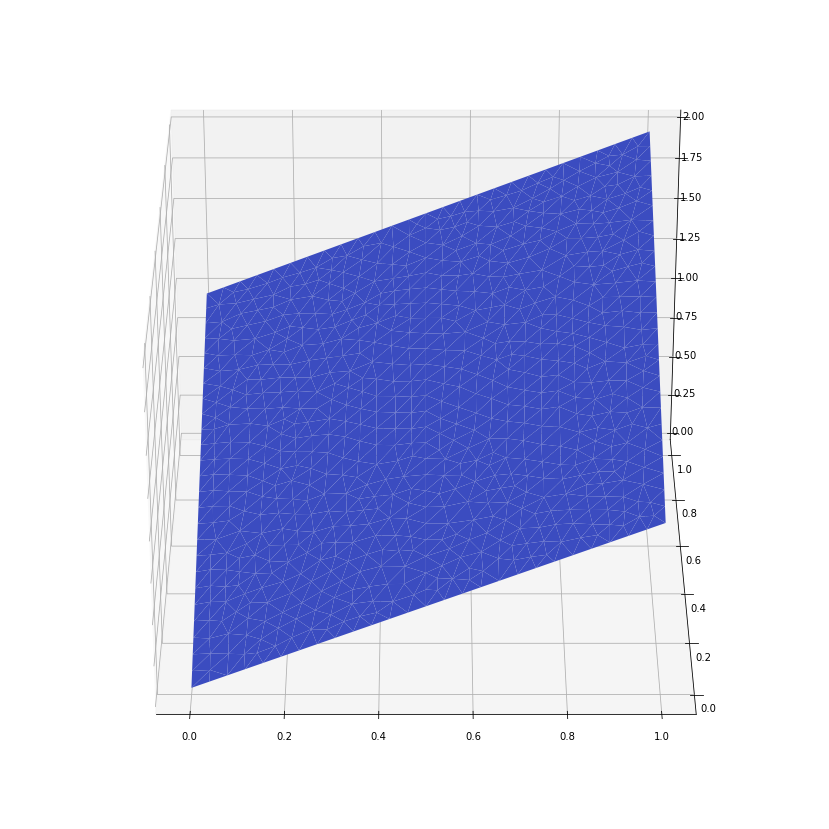

In [46]:
#try to assign a field of nodal values and look at how it is reconstructed
field = np.zeros(Nnode)
for n in range(Nnode):
    [x,y] = nodes[n][0:2]
    field[n] = x+y

fig = plt.figure(figsize = (15,15))
ax  = fig.add_subplot(111, projection='3d')
ax.azim = -90
for k in range(Nelements):
    xx = np.zeros(3)
    yy = np.zeros(3)
    nodal_values = np.zeros(3)
    for i in range(3):
        xx[i], yy[i] = nodes[elements[k][i]][0:2]
        nodal_values [i] = field[elements[k][i]]
    reconstruction = np.dot(REC[k],nodal_values)
    surf = ax.plot_trisurf(xx,yy, reconstruction, cmap=cm.coolwarm)

In [48]:
print (REC[4])

[[ 1.00000000e+00 -1.02163121e-15 -1.44998131e-15]
 [-1.13734972e-15  1.00000000e+00  8.48725168e-16]
 [ 1.82859796e-16  2.32105232e-15  1.00000000e+00]]


In [47]:
print (B1)

[[ 8.97749045e-19 -5.03984604e-19 -3.87305815e-19]
 [ 1.90170934e-07  4.45539371e-07 -6.35710305e-07]
 [-5.64552733e-07  4.41803371e-07  1.22749361e-07]]


In [33]:
for i in range(3):
    for j in range(3):
        print (chi[i][j](1.,1.))

[-3.35101317e-05  1.32056749e-04]
[-3.35101317e-05  1.32056749e-04]
[-3.35101317e-05  1.32056749e-04]
[-3.50973231e-06  2.76623108e-05]
[-3.50973231e-06  2.76623108e-05]
[-3.50973231e-06  2.76623108e-05]
[-1.45873259e-06  2.87428717e-06]
[-1.45873259e-06  2.87428717e-06]
[-1.45873259e-06  2.87428717e-06]


In [29]:
vec = np.array([1.,1.])
fun = lambda x:  vec*x

fun(1.)

array([1., 1.])

In [31]:
vec = np.array([2.,2.])
fun (1.)

array([2., 2.])

In [58]:
it

190